In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.multioutput import MultiOutputRegressor

In [42]:
# Load data
data = pd.read_csv('merged_v2.csv')

# Drop long and lat
data.drop(columns=['longitude', 'latitude'], inplace=True)

# Check first rows
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        2584 non-null   object 
 1   Soil group  2584 non-null   object 
 2   Land class  2584 non-null   object 
 3   Soil type   2584 non-null   object 
 4   pH          2584 non-null   float64
 5   SOC         2584 non-null   float64
 6   Nitrogen    2584 non-null   float64
 7   Potassium   2584 non-null   float64
 8   Phosphorus  2584 non-null   float64
 9   Sulfur      2584 non-null   float64
 10  Boron       2584 non-null   float64
 11  Zinc        2584 non-null   float64
 12  Sand        2584 non-null   float64
 13  Silt        2584 non-null   float64
 14  Clay        2584 non-null   float64
dtypes: float64(11), object(4)
memory usage: 302.9+ KB


In [43]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Define columns
numerical_cols = ['pH', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Sand', 'Silt', 'Clay']
categorical_cols = ['Area', 'Soil group', 'Land class', 'Soil type']
target_cols = ['SOC', 'Boron', 'Zinc']

# Split data into features (X) and targets (y)
X = data.drop(columns=target_cols)
y = data[target_cols]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        # One-hot encode categorical features
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        # Scale numerical features
        ('scaler', MinMaxScaler(), numerical_cols)
    ],
    remainder='drop'  # Drop any columns not specified (raw categorical columns)
)

models = {
    'LinearRegression': MultiOutputRegressor(LinearRegression()),
    'DecisionTree': MultiOutputRegressor(DecisionTreeRegressor()),
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(random_state=0)),
    'AdaBoost': MultiOutputRegressor(AdaBoostRegressor(random_state=0)),
    'Bagging': MultiOutputRegressor(BaggingRegressor(random_state=0)),
    'KNeighbors': MultiOutputRegressor(KNeighborsRegressor()),
    'SVR': MultiOutputRegressor(SVR()),
    'XGB': MultiOutputRegressor(XGBRegressor(random_state=0))
}

# Dictionary to store results
results = {}
feature_importances = {}

for model_name, model in models.items():
    # Create a pipeline for each model
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('model', model)
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the model
    rmse = mean_squared_error(y_test, y_pred, squared=False, multioutput='raw_values')
    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')
    
    # Store performance metrics for each target variable
    results[model_name] = {
        'RMSE': dict(zip(target_cols, rmse)),
        'MAE': dict(zip(target_cols, mae)),
        'R²': dict(zip(target_cols, r2))
    }
    
    # Permutation importance
    preprocessed_X_test = pipeline.named_steps['preprocessing'].transform(X_test)
    for target_idx, target_name in enumerate(target_cols):
        perm_importance = permutation_importance(
            model.estimators_[target_idx] if hasattr(model, 'estimators_') else model,
            preprocessed_X_test,
            y_test.iloc[:, target_idx],
            n_repeats=5,
            random_state=0
        )
        
        # Store feature importance for this model and target
        feature_importance_df = pd.DataFrame({
            'Feature': preprocessor.get_feature_names_out(),
            'Importance': perm_importance.importances_mean
        }).sort_values(by='Importance', ascending=False)
        feature_importances[(model_name, target_name)] = feature_importance_df

# --------------------- Results and Visualization ---------------------
# Print model performance
for model_name, metrics in results.items():
    print(f"Performance for {model_name}:")
    for target, metric in metrics.items():
        print(f"  {target}: {metric}")
    print("-" * 30)


Performance for LinearRegression:
  RMSE: {'SOC': 0.28830424064353627, 'Boron': 0.080142909888265, 'Zinc': 0.3867773074733052}
  MAE: {'SOC': 0.1901251460952611, 'Boron': 0.04547553364754593, 'Zinc': 0.27868228805004835}
  R²: {'SOC': 0.8102802041776458, 'Boron': 0.6703786112605429, 'Zinc': 0.43627407197054235}
------------------------------
Performance for DecisionTree:
  RMSE: {'SOC': 0.39755587800154374, 'Boron': 0.10853051882110441, 'Zinc': 0.4470297201755885}
  MAE: {'SOC': 0.25183351257253384, 'Boron': 0.0634683786073501, 'Zinc': 0.3313353249516441}
  R²: {'SOC': 0.6392494966036355, 'Boron': 0.39551026707432346, 'Zinc': 0.2469586333173076}
------------------------------
Performance for RandomForest:
  RMSE: {'SOC': 0.28879785083387, 'Boron': 0.08177053248961696, 'Zinc': 0.341139222662985}
  MAE: {'SOC': 0.18226878390715667, 'Boron': 0.04649181494777563, 'Zinc': 0.25364664065764025}
  R²: {'SOC': 0.8096300035971995, 'Boron': 0.656854093492797, 'Zinc': 0.561459861179999}
----------

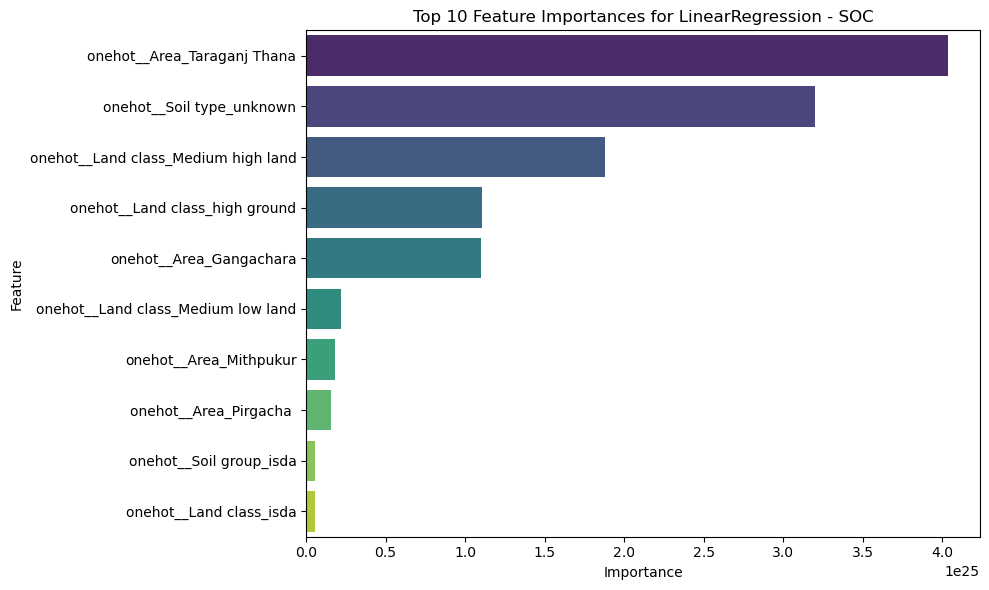

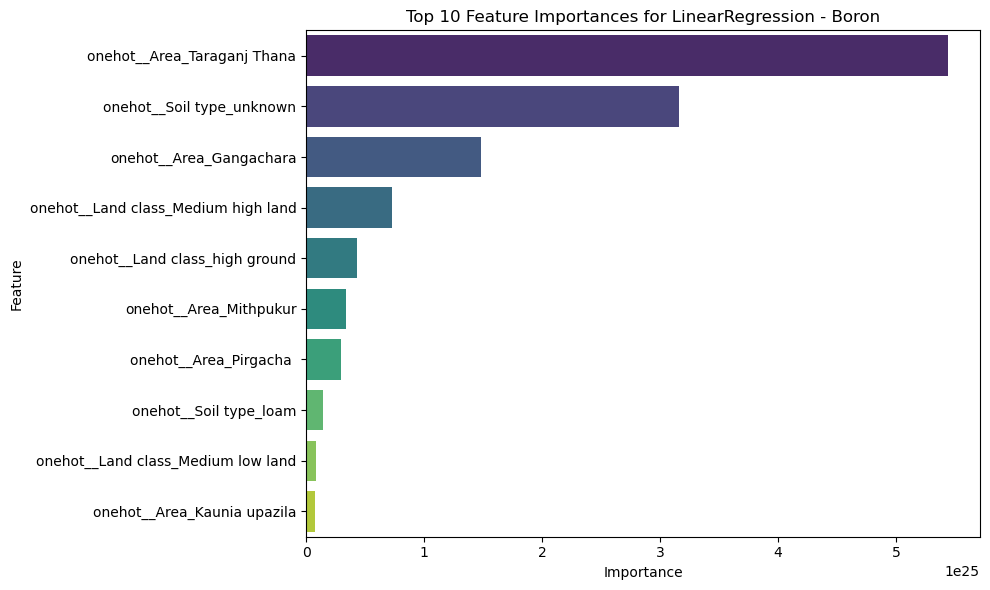

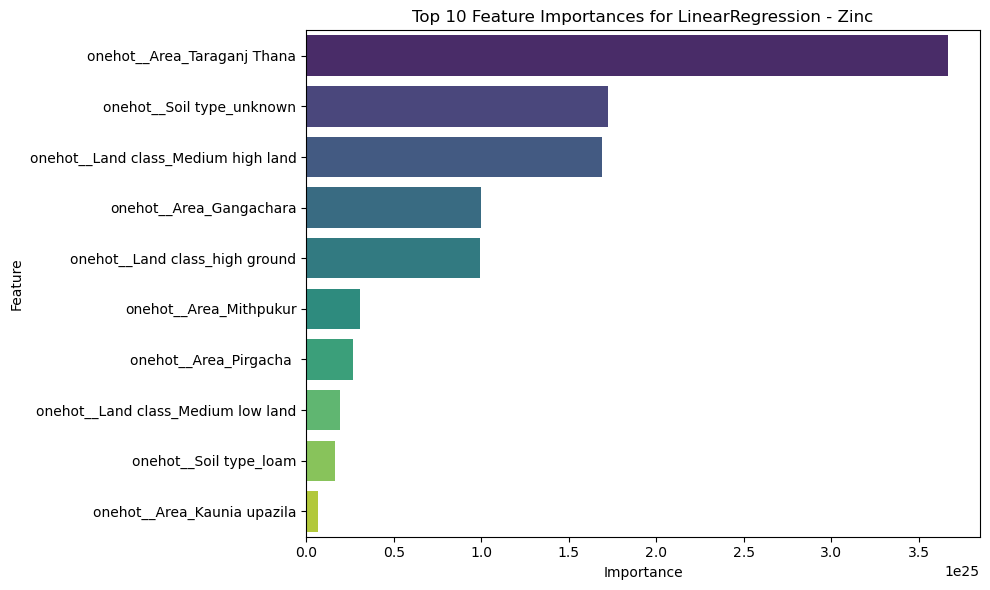

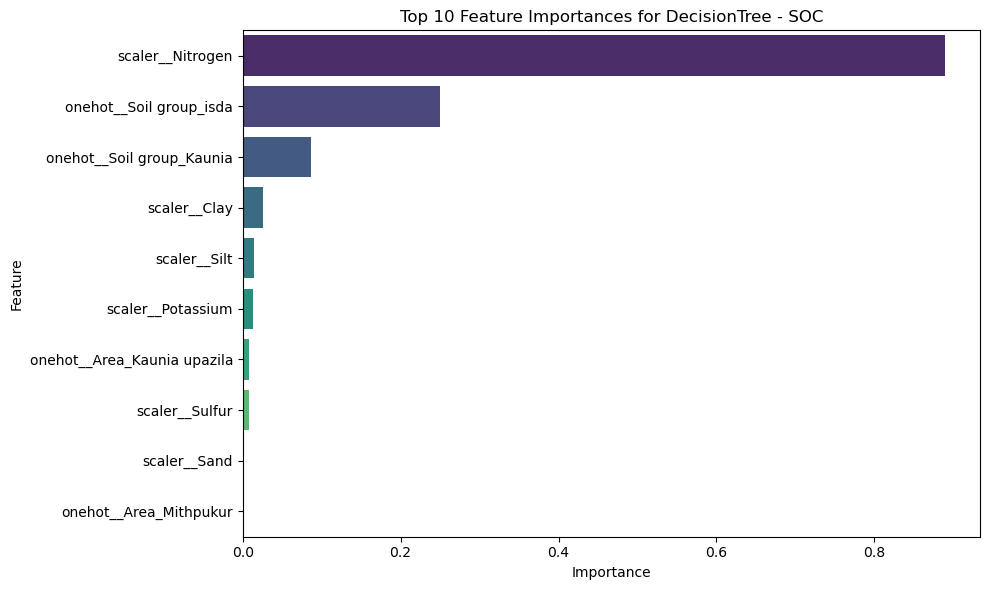

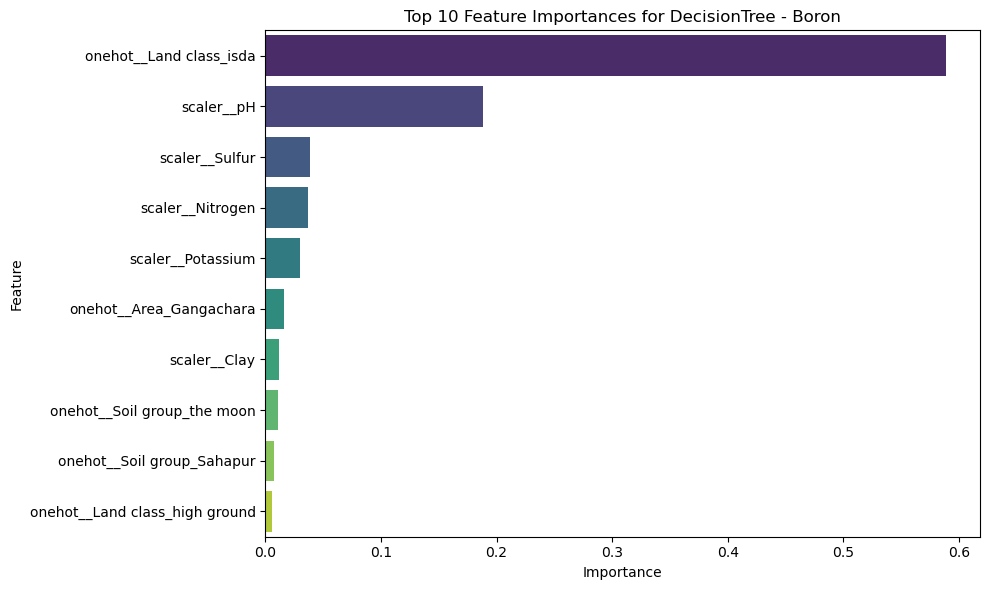

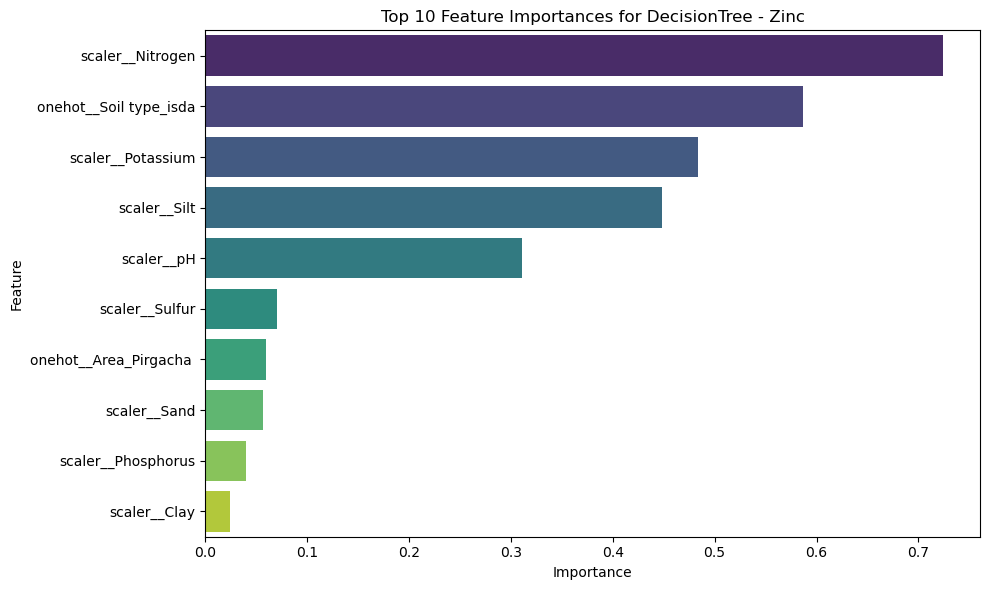

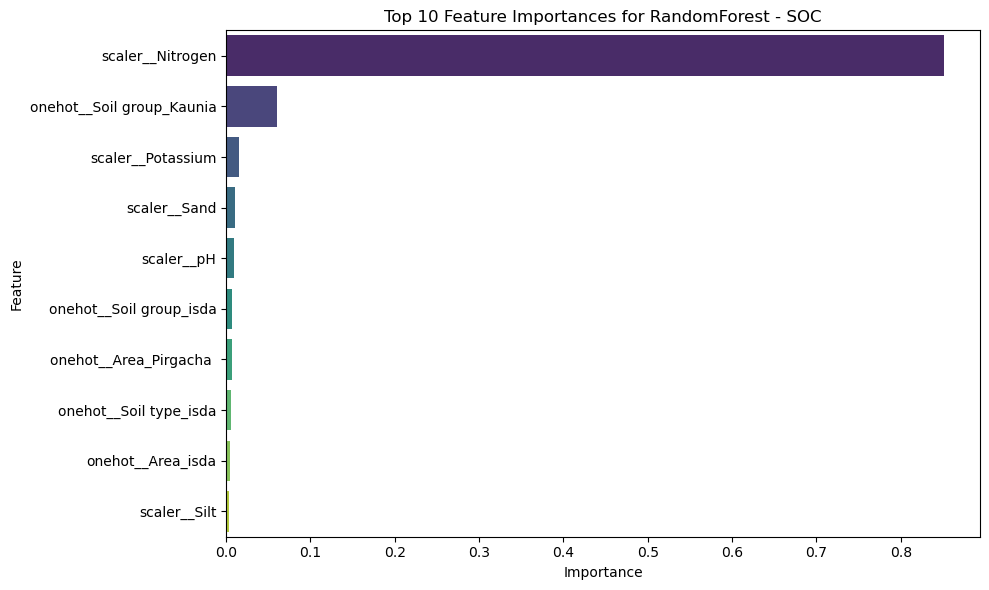

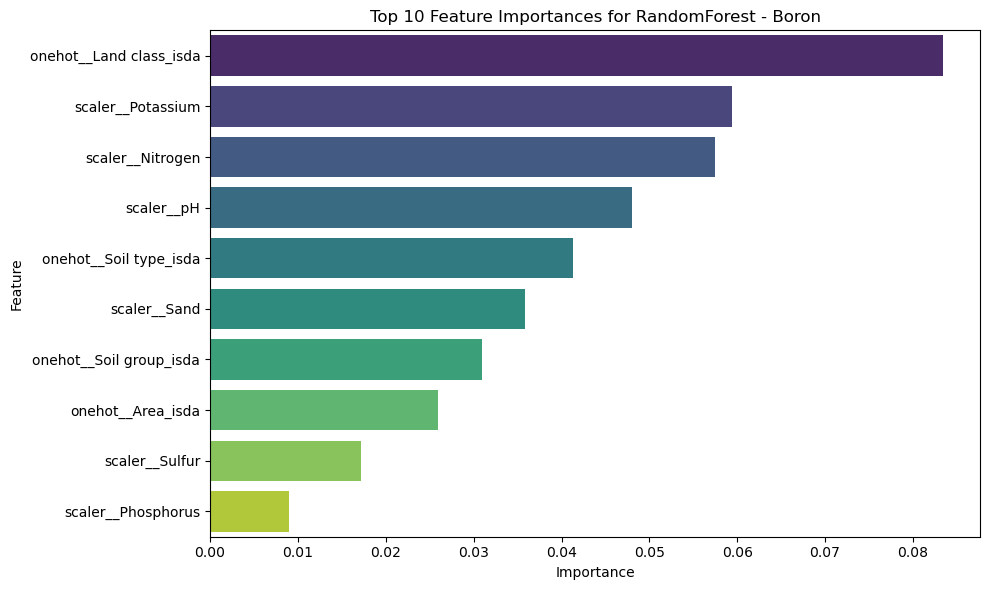

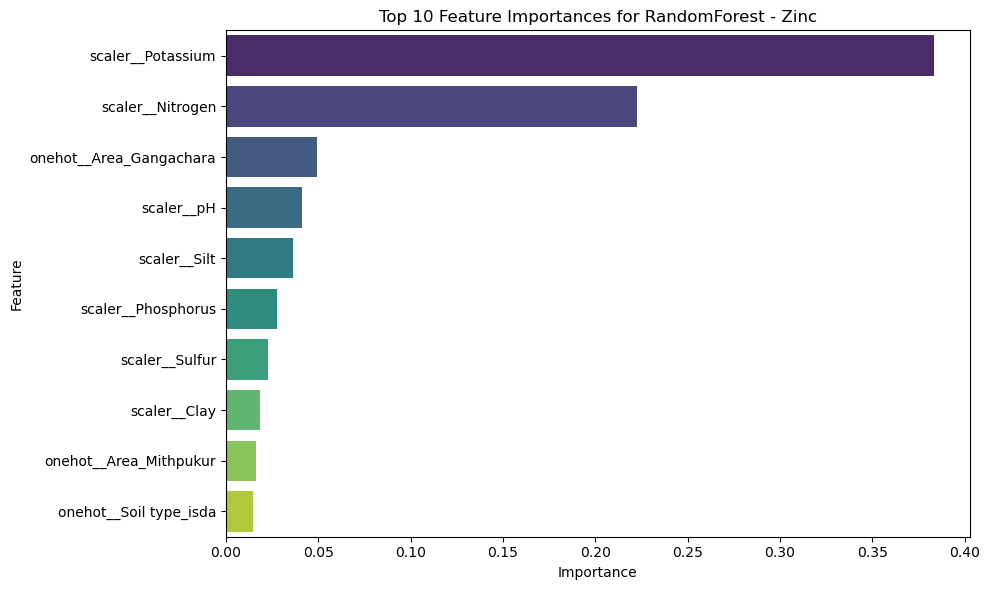

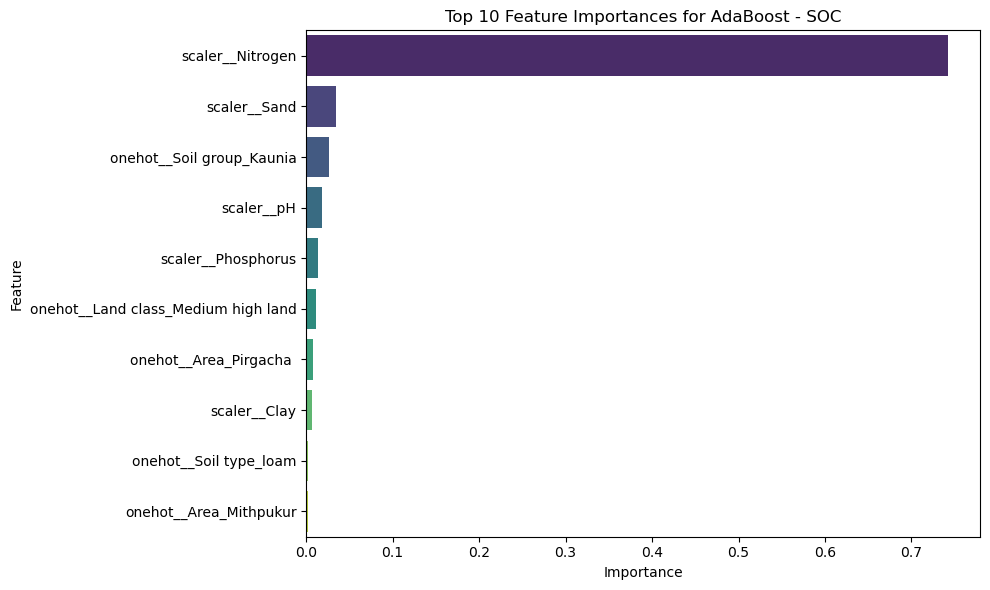

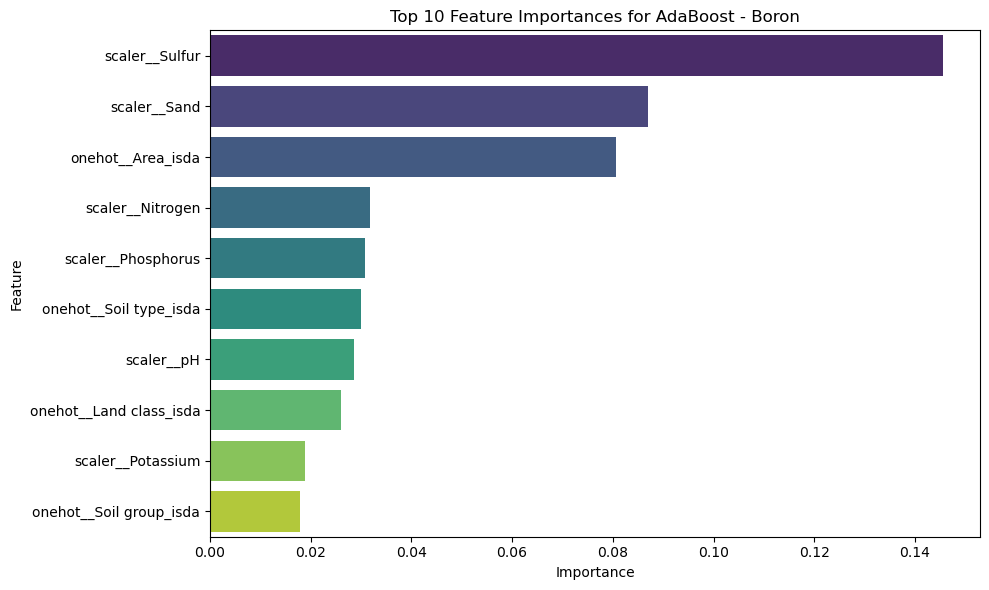

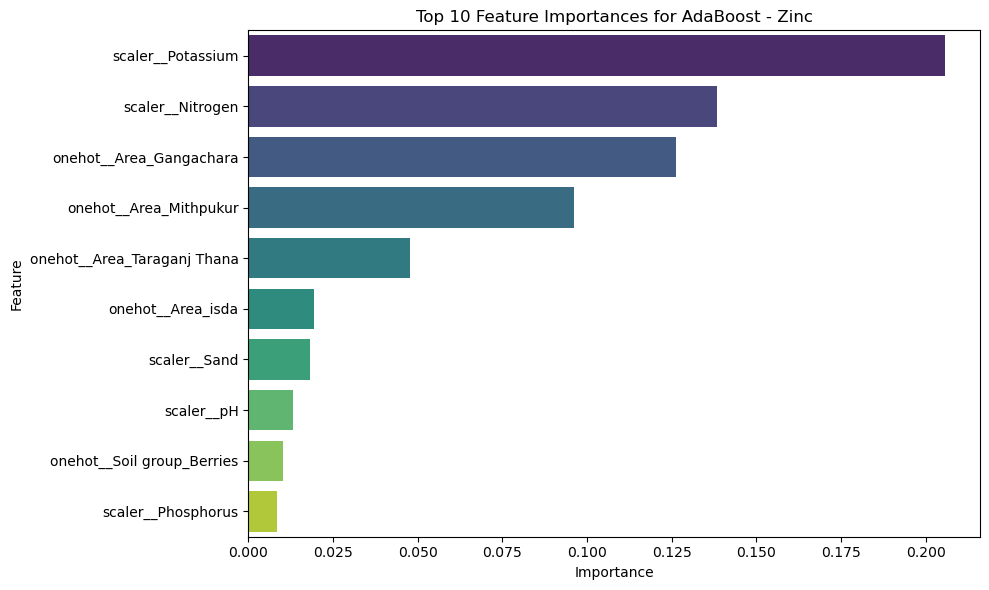

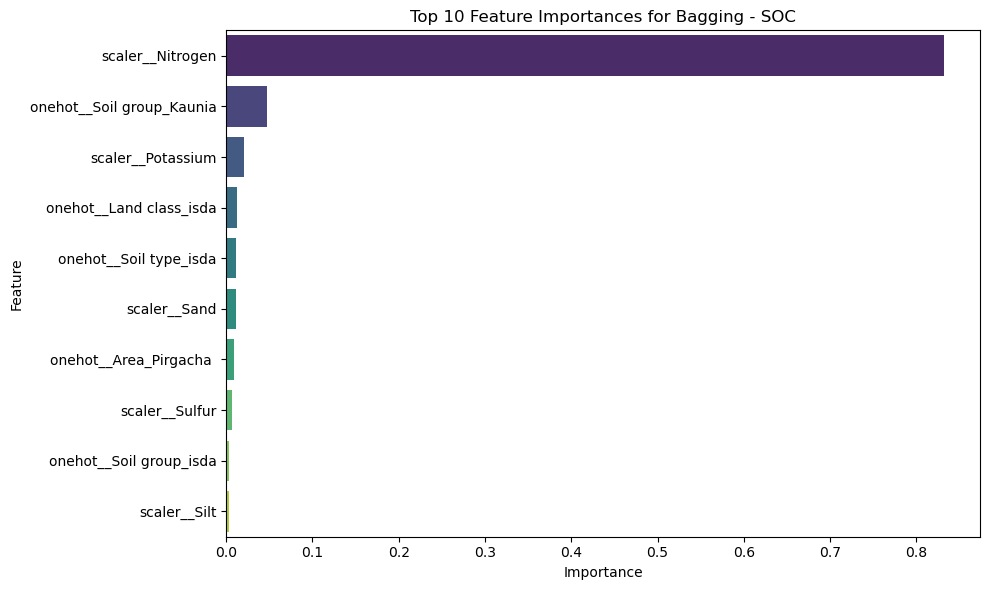

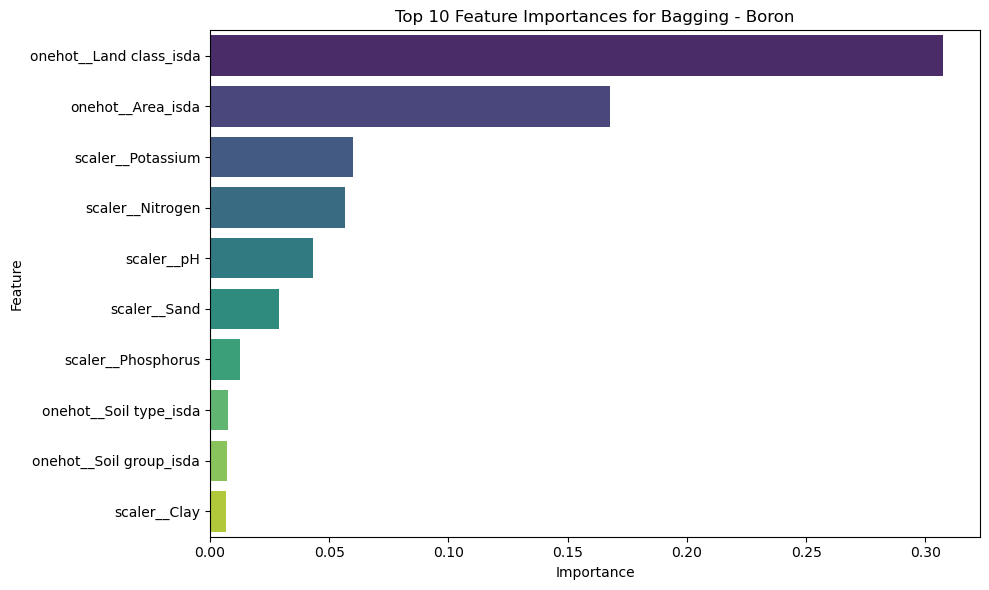

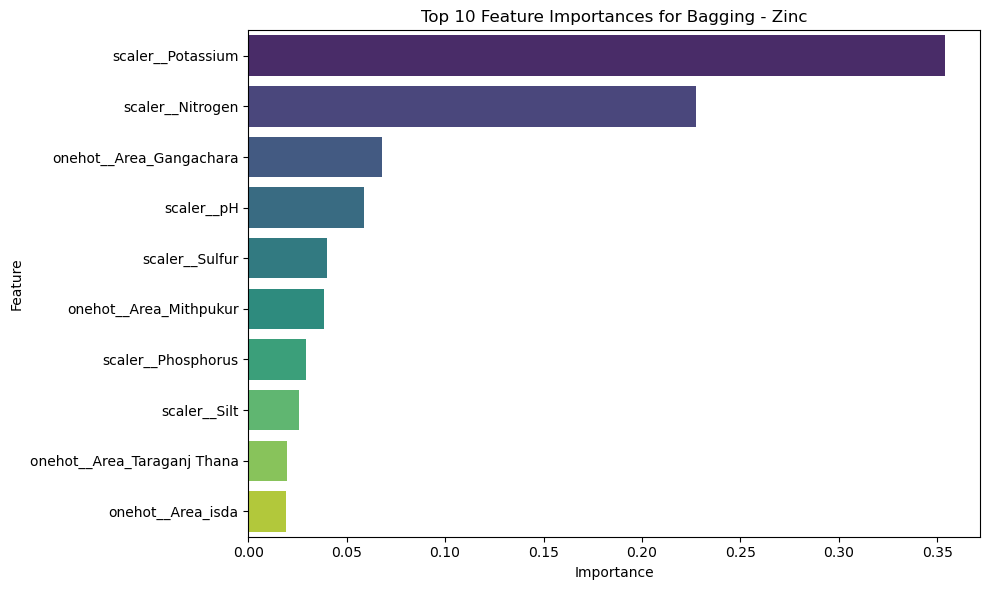

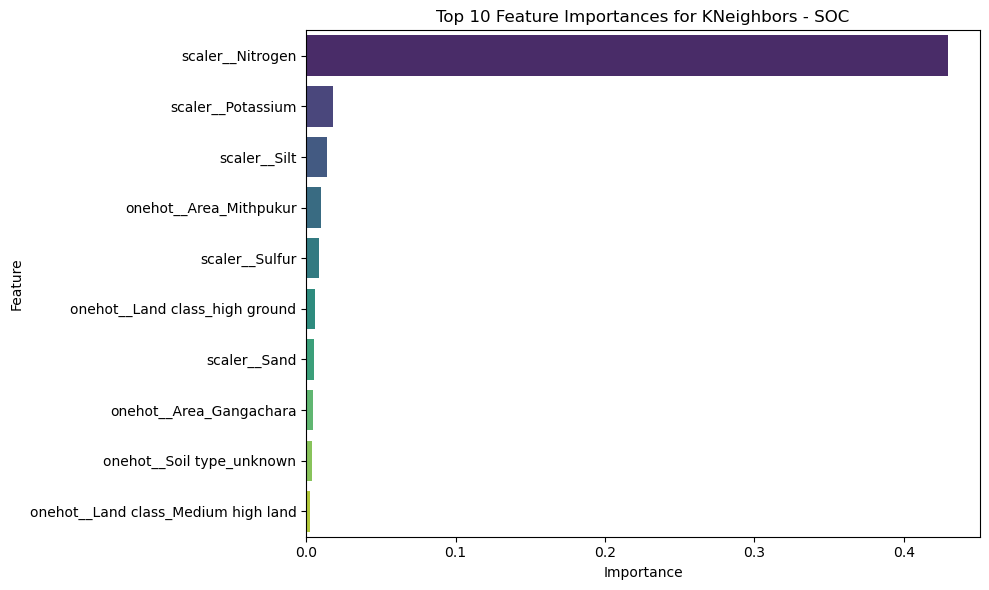

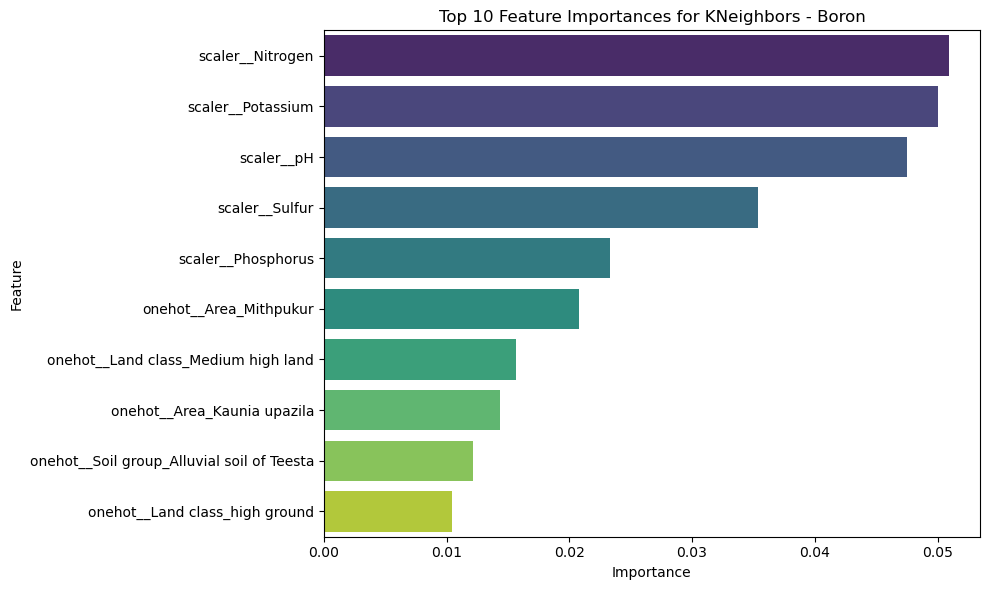

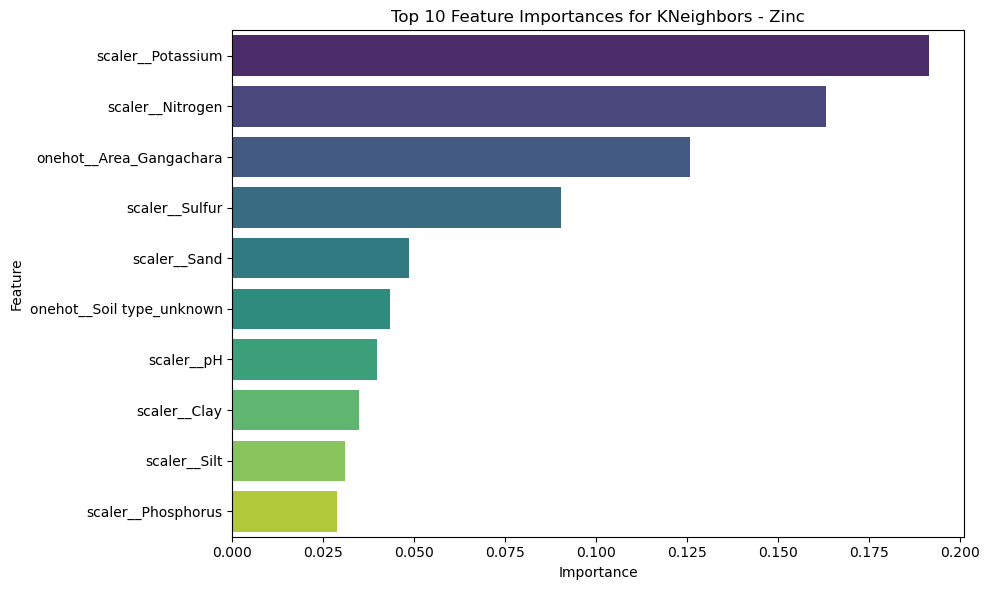

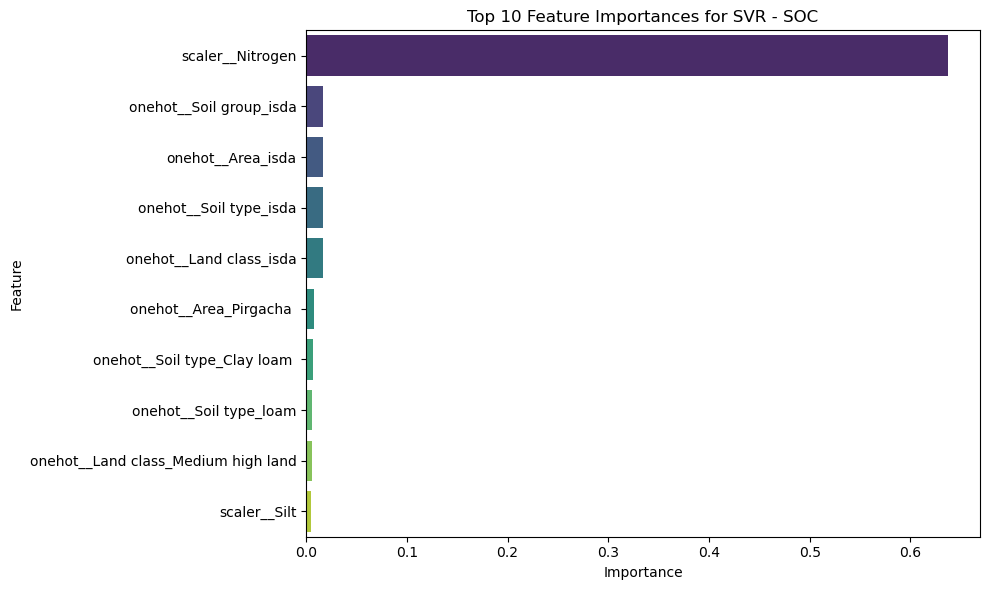

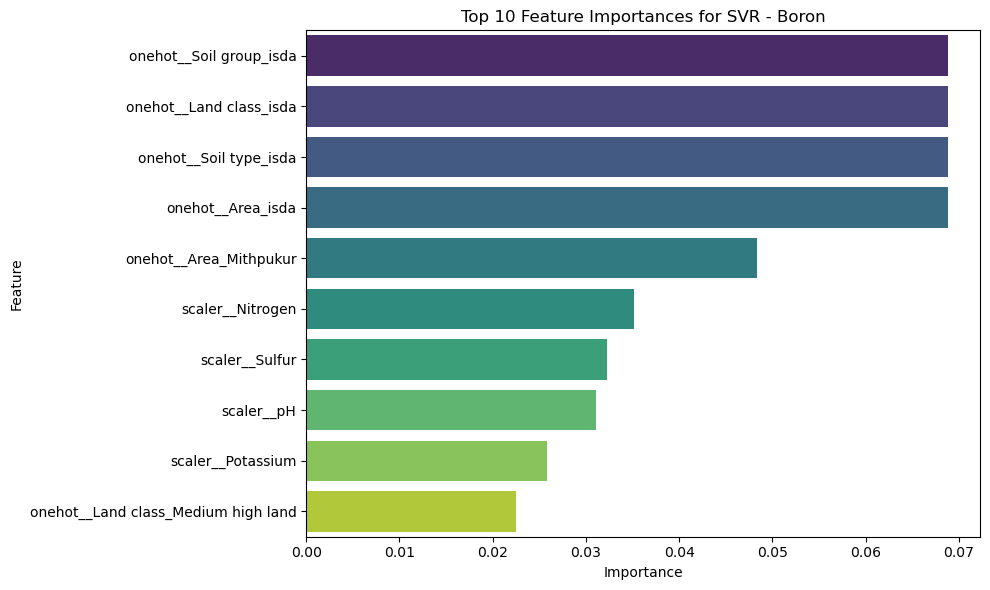

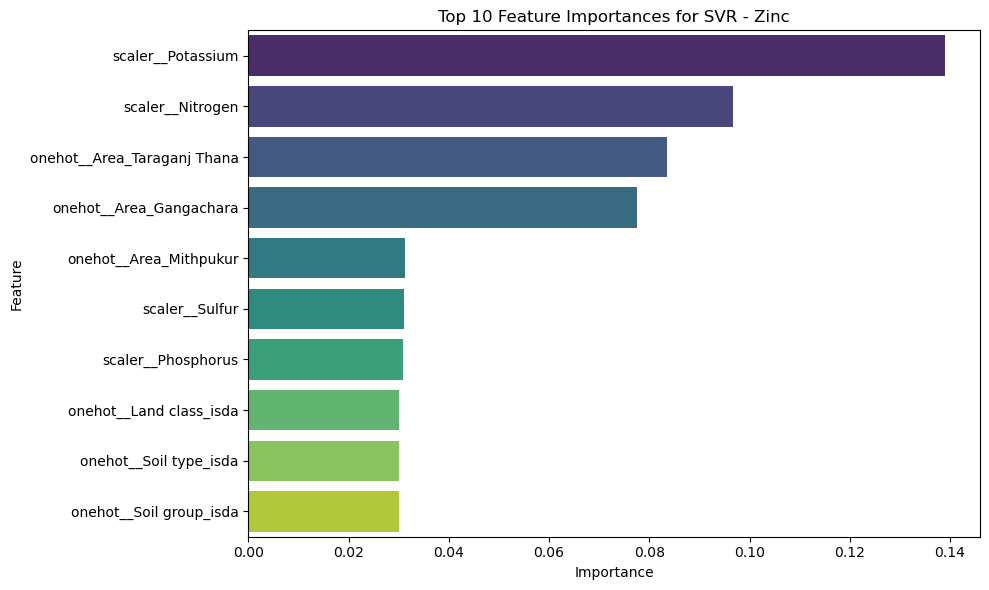

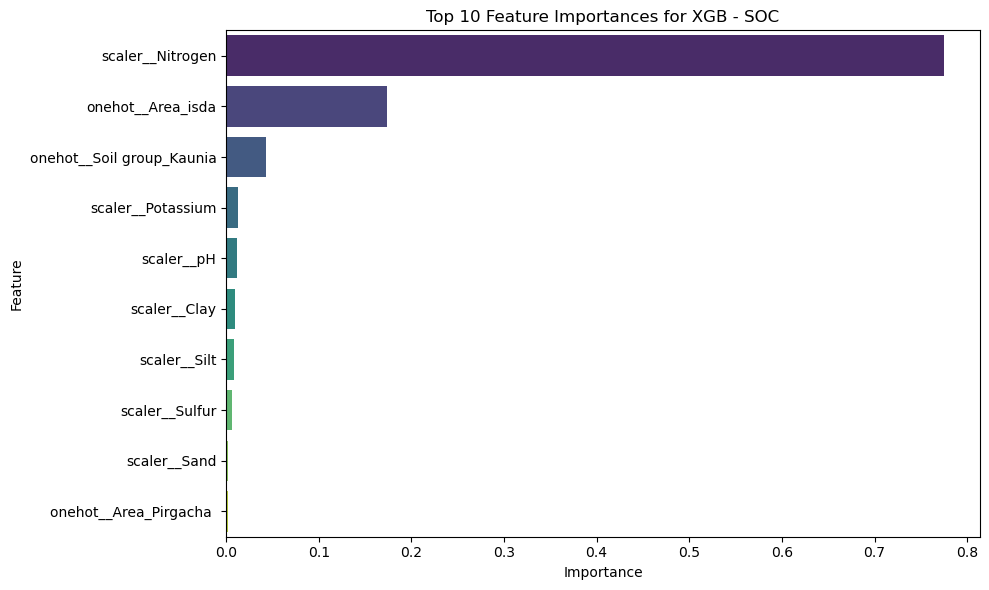

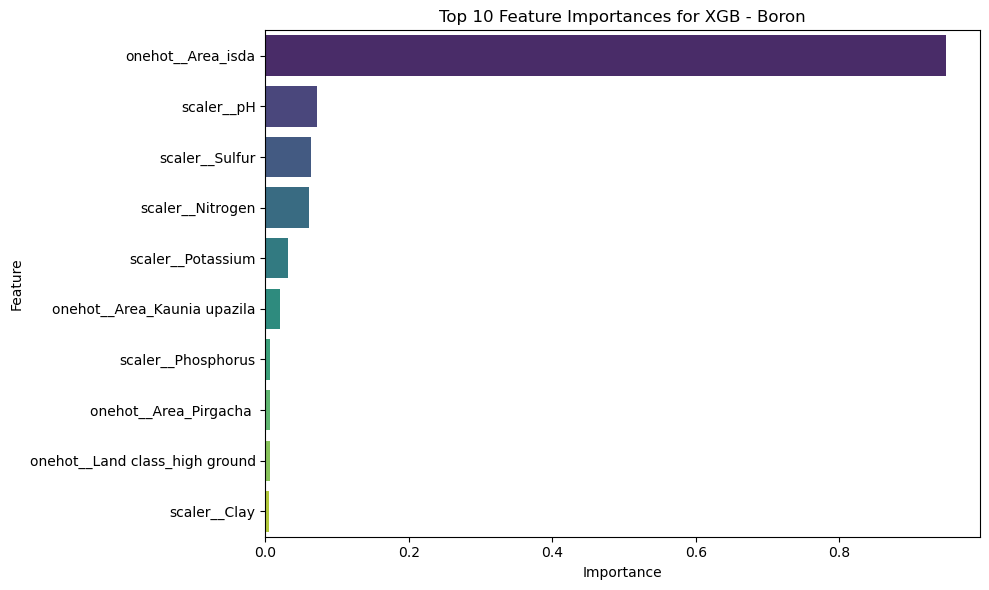

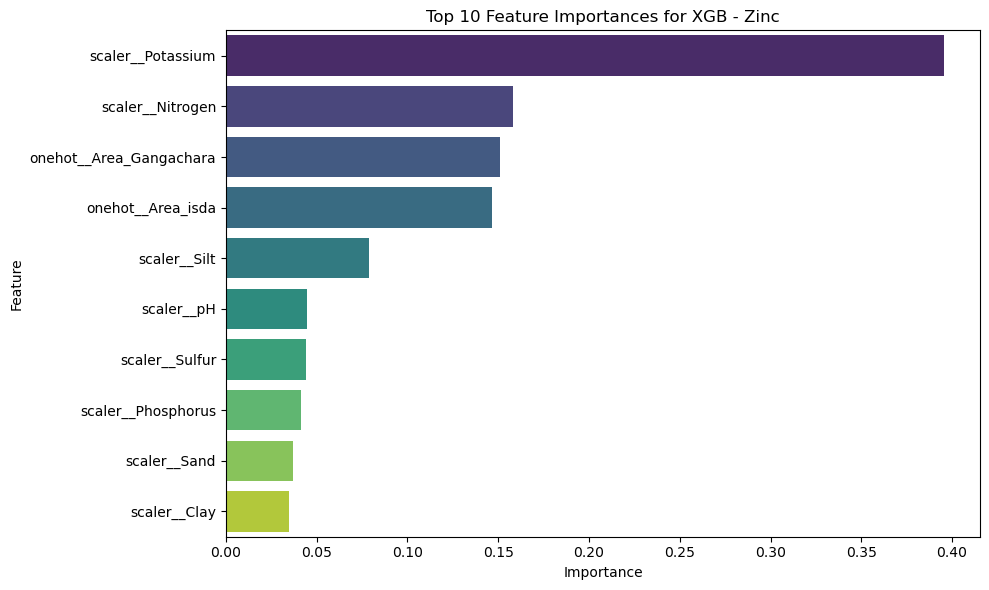

In [50]:
# Visualize top 10 feature importances with Viridis color scheme using Seaborn
for (model_name, target_name), importance_df in feature_importances.items():
    top_10_features = importance_df.head(10).sort_values(by='Importance', ascending=False)

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=top_10_features, 
        palette='viridis',
        hue='Feature',
        legend=False
    )
    plt.title(f"Top 10 Feature Importances for {model_name} - {target_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


### **Model Selection Rationale**

I am more inclined to explore models where **numerical features** have higher importance because they are likely to generalize better to unseen data. This will be critical when **categorical features** used in the model aren't present in unseen data.

#### **Selected Models**:
- **Random Forest**:
  - Suitable for predicting **SOC** and **Zinc**.
- **Adaboost**:
  - Chosen for **Boron** prediction.
- **XGBoost**:
  - Effective for predicting **SOC** and **Zinc**.


### **To-Do List**

1. **Clustering**:
   - Explore clustering based on **longitude/latitude** data instead of one-hot encoding for **soil group** and **area**.

2. **Feature Engineering**:
   - Use combinations of **nutrients** and **physical soil characteristics** (e.g., sand, silt, clay) to create new features.

3. **Hyperparameter Tuning**:
   - Perform hyperparameter tuning on the **chosen models** to optimize performance.
